In [10]:
from face_recognition import FaceRecognition
import cv2
import numpy as np
import os

In [2]:
app = FaceRecognition()
app.prepare(ctx_id=0, det_size=(640, 640))
app.read_facebase("./img/targets")

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'device_id': '0'}}
find model: /home/geez0219/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'device_id': '0'}}
find model: /home/geez0219/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExec

## Test

In [3]:
test_path = "./img/test"
test_embedding = {}

for name in os.listdir(test_path):
    tmp = []
    for file in os.scandir(os.path.join(test_path, name)):
        if file.is_file():
            img = cv2.imread(file.path)
            tmp.append(app.get_single_features(img))
    test_embedding[name] = tmp

In [12]:
def get_group_state(threshold, test_embedding, app):
    TP, FP, FN, TN = 0, 0, 0, 0
    for label, vecs in test_embedding.items():
        for vec in vecs:
            if vec is None:
                continue
            predicted = app.classify(vec, threshold)
            if not label.startswith("other") and predicted != "other":
                TP += 1
            elif label.startswith("other") and predicted != "other":
                FP += 1
            elif not label.startswith("other") and predicted == "other":
                FN += 1
            else:
                TN += 1
    return TP, FP, FN, TN

In [13]:
def plot_ROC_curve(test_embedding, app, points=100):
    import matplotlib.pyplot as plt
    thresholds = np.linspace(0, 1, points)
    
    precisions = []
    recalls = []
    t_pre = []
    t_rec = []
    for t in thresholds:
        TP, FP, FN, TN = get_group_state(t, test_embedding, app)
        if (TP + FP) != 0:
            precisions.append(TP / (TP + FP))
            t_pre.append(t)
        if (TP + FN) != 0:
            recalls.append(TP / (TP + FN))
            t_rec.append(t)
        
    fig, ax = plt.subplots()

    # Using set_dashes() to modify dashing of an existing line
    line1, = ax.plot(t_pre, precisions, label='precision')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line2, = ax.plot(t_rec, recalls, label='recall')

    ax.legend()
    plt.show()

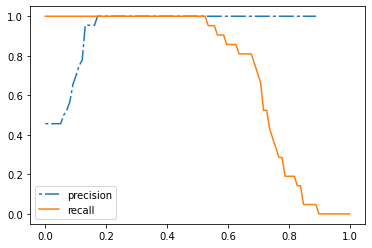

In [14]:
plot_ROC_curve(test_embedding, app, points=100)